# Galaxy Rotation Curve

In [1]:
#importing packages
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.optimize import curve_fit

In [2]:
#defining where data is and where to save images
datapath = '/home/asimpson/Astro361/Lab8/galaxyData/'
savedir = '/mnt/c/Users/loabn/Desktop/lab8imgs/'

In [3]:
#getting calibration file name
calibfile = glob.glob(datapath+'calib*')

In [4]:
#reading in data from calibration file
for file in calibfile:
    with open(file) as inData:
        spectrum_rows = []
        for i, row in enumerate(inData, start=1):
            if i%4 ==0:
                spectrum_rows.append(row)
            if i==1:
                values = [item for item in row.split(' ') if len(item)!=0]
                for j, val in enumerate(values, start=0):
                    if val =='vlsr':
                        calib_vlsrval = np.float64(values[j+1])

        full_spectrum = np.zeros(1024)
        for row in spectrum_rows:
            values = row.split(' ')
            spec = [np.float64(val) for val in values if val!='\n' and val!=' ' and val!='']
            full_spectrum += spec
            
        calib_spec =(np.asarray(full_spectrum)/len(spectrum_rows))

In [5]:
#getting names of all data files
files = glob.glob(datapath+'galpos*dat')

In [6]:
#reading in data, longitude, and vlsr
spectra_unsort = []
vlsrs_unsort = []
long_unsort = []

for file in files:
    
    currentlong = file.split('.')[0][-2:]
        
    long_unsort.append(np.float64(currentlong))
    
    
    with open(file) as inData:
        spectrum_rows = []
        for i, row in enumerate(inData, start=1):
            if i%4 ==0:
                spectrum_rows.append(row)
            if i==1:
                values = [item for item in row.split(' ') if len(item)!=0]
                for j, val in enumerate(values, start=0):
                    if val =='vlsr':
                        vlsrval = np.float64(values[j+1])
                        vlsrs_unsort.append(vlsrval)

        full_spectrum = np.zeros(1024)
        for row in spectrum_rows:
            values = row.split(' ')
            spec = [np.float64(val) for val in values if val!='\n' and val!=' ' and val!='']
            full_spectrum += spec
            
        spectra_unsort.append(np.asarray(full_spectrum)/len(spectrum_rows))

In [7]:
#sorting the spectra, vlsr, and longitude
spectra = [x[0] for x in sorted(zip(spectra_unsort, vlsrs_unsort, long_unsort), key = lambda p : p[2])]
vlsrs = [x[1] for x in sorted(zip(spectra_unsort, vlsrs_unsort, long_unsort), key = lambda p : p[2])]
long = [x[2] for x in sorted(zip(spectra_unsort, vlsrs_unsort, long_unsort), key = lambda p : p[2])]

In [8]:
#defining the frequency domain
max_freq = 1426.000
min_freq = 1416.000
spacing = 0.009766
freqs = np.arange(min_freq, max_freq, spacing)

In [9]:
#subtracting off calibration spectrum from each spectra
calib_spectra = [list(np.asarray(spec)-np.asarray(calib_spec)) for spec in spectra]

In [10]:
#defining the rest frame frequency
rest_freq = (2.99792e8/0.2110611405413)/1e6 #in MHz

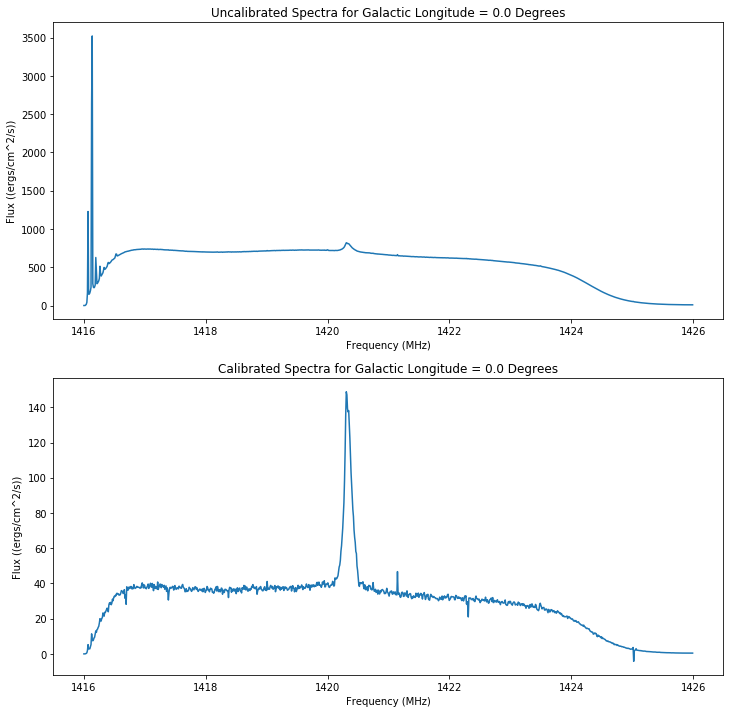

In [11]:
#plotting calibrated and uncalibrated spectra
fig, axs = plt.subplots(2,1, figsize=(12,12))
for spec, lon in zip(spectra[0:1],long[0:1]):
    axs[0].plot(freqs, spec,label=lon)
    axs[0].set_xlabel('Frequency (MHz)')
    axs[0].set_ylabel('Flux ((ergs/cm^2/s))')
    axs[0].set_title('Uncalibrated Spectra for Galactic Longitude = 0.0 Degrees')
    #axs[0].legend(title='Galactic Longitude')
    
for spec, lon in zip(calib_spectra[0:1],long[0:1]):
    axs[1].plot(freqs, spec,label=lon)
    axs[1].set_xlabel('Frequency (MHz)')
    axs[1].set_ylabel('Flux ((ergs/cm^2/s))')
    axs[1].set_title('Calibrated Spectra for Galactic Longitude = 0.0 Degrees')
    #axs[1].legend(title='Galactic Longitude', loc='lower right')
    
#plt.savefig(savedir+'calibvuncalib.png')

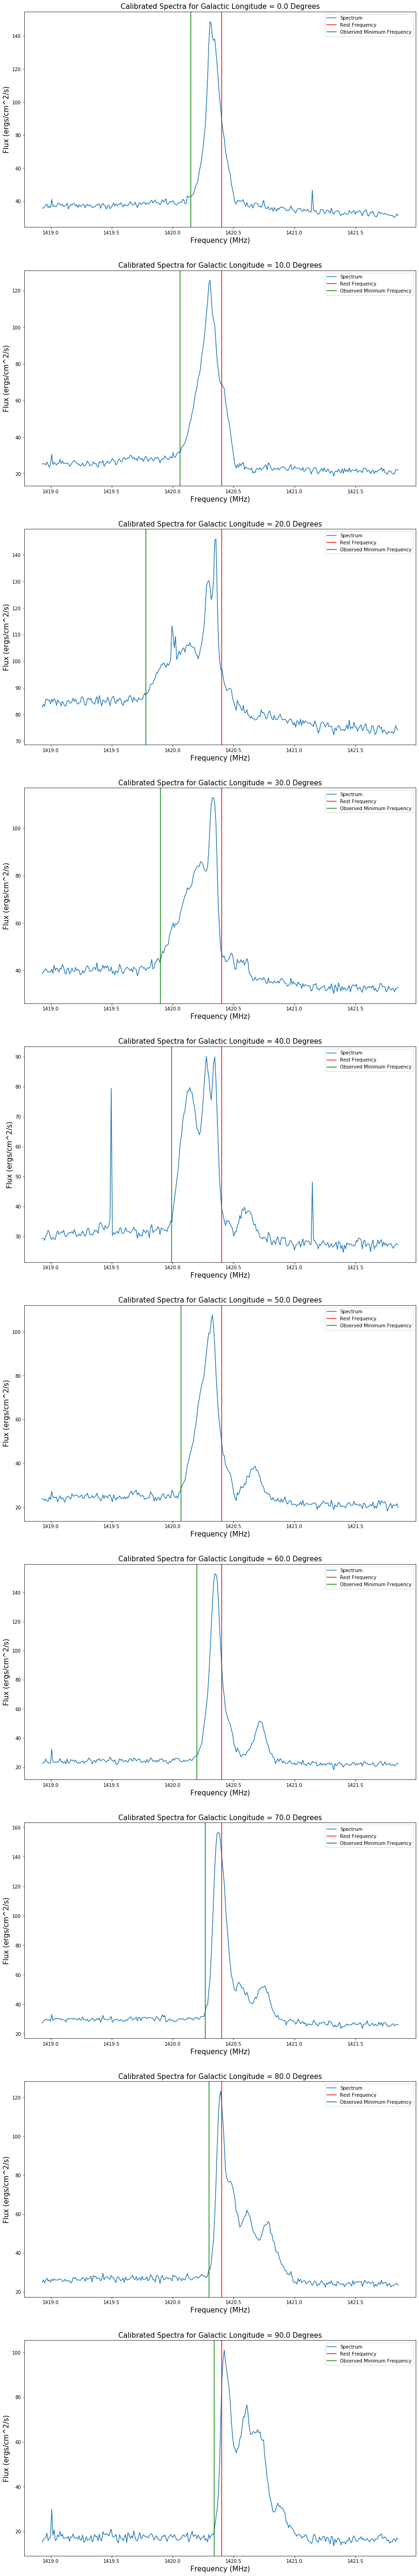

In [43]:
#finding the minimum frequency/fastest velocity for every longitude
fig, axs = plt.subplots(10,1, figsize=(15,100))

min_freqs = [1420.15, 1420.06, 1419.78, 1419.9, 1419.99, 1420.07, 1420.2, 1420.27, 1420.30, 1420.34]

i=0
n=0

for spec, lon in zip(calib_spectra,long):
    axs[i].plot(freqs[300:600], spec[300:600], label='Spectrum')
    axs[i].set_xlabel('Frequency (MHz)', fontsize=15)
    axs[i].set_ylabel('Flux (ergs/cm^2/s)', fontsize=15)
    axs[i].set_title('Calibrated Spectra for Galactic Longitude = {} Degrees'.format(lon), fontsize=15)
    axs[i].axvline(rest_freq, c='r', label = 'Rest Frequency')
    axs[i].axvline(min_freqs[n], c='g', label = 'Observed Minimum Frequency')
    axs[i].legend()
    i+=1
    n+=1
    #plt.savefig(savedir+'findfreq.png')

In [13]:
#defining function to get velocity from frequency
def getvel(freq):
    
    vel = -2.99792e5*((freq-rest_freq)/(rest_freq))
    return vel

In [14]:
#function to get sun frequency
def findsunvel(long):
    V0 = 255 #km/s
    sunvel = V0*np.sin(np.pi*(long)/180)
    
    return sunvel

In [15]:
#finding minimum velocities for errors
def findminsunvel(long):
    sunerr = 5.1
    V0 = 255-sunerr #km/s
    sunvel = V0*np.sin(np.pi*(long)/180)
    
    return sunvel

In [16]:
#finding maximum velocities for errors
def findmaxsunvel(long):
    sunerr = 5.1
    V0 = 255+sunerr #km/s
    sunvel = V0*np.sin(np.pi*(long)/180)
    
    return sunvel

In [17]:
#finding radius from galactic center from longitude
def findradius(long):
    R0 = 8.34 #kpc
    rad = R0*np.sin(np.pi*long/180)
    return rad

In [35]:
#finding the corrected velocity and getting all radii, also finidng error sizes
vels = [getvel(f) for f in min_freqs]

sun_vels = [findsunvel(l) for l in long]
min_sun_vels = [findminsunvel(l) for l in long]
max_sun_vels = [findmaxsunvel(l) for l in long]

radii = [findradius(l) for l in long]

correct_vels = [v-vlsr+sun for v, vlsr, sun in zip(vels, vlsrs, sun_vels)]
min_vels = [np.abs(cvel-(v-vlsr+sun)) for cvel, v, vlsr, sun in zip(correct_vels, vels, vlsrs, min_sun_vels)]
max_vels = [np.abs(cvel-(v-vlsr+sun)) for cvel, v, vlsr, sun in zip(correct_vels, vels, vlsrs, max_sun_vels)]

errors = np.array([min_vels, max_vels])

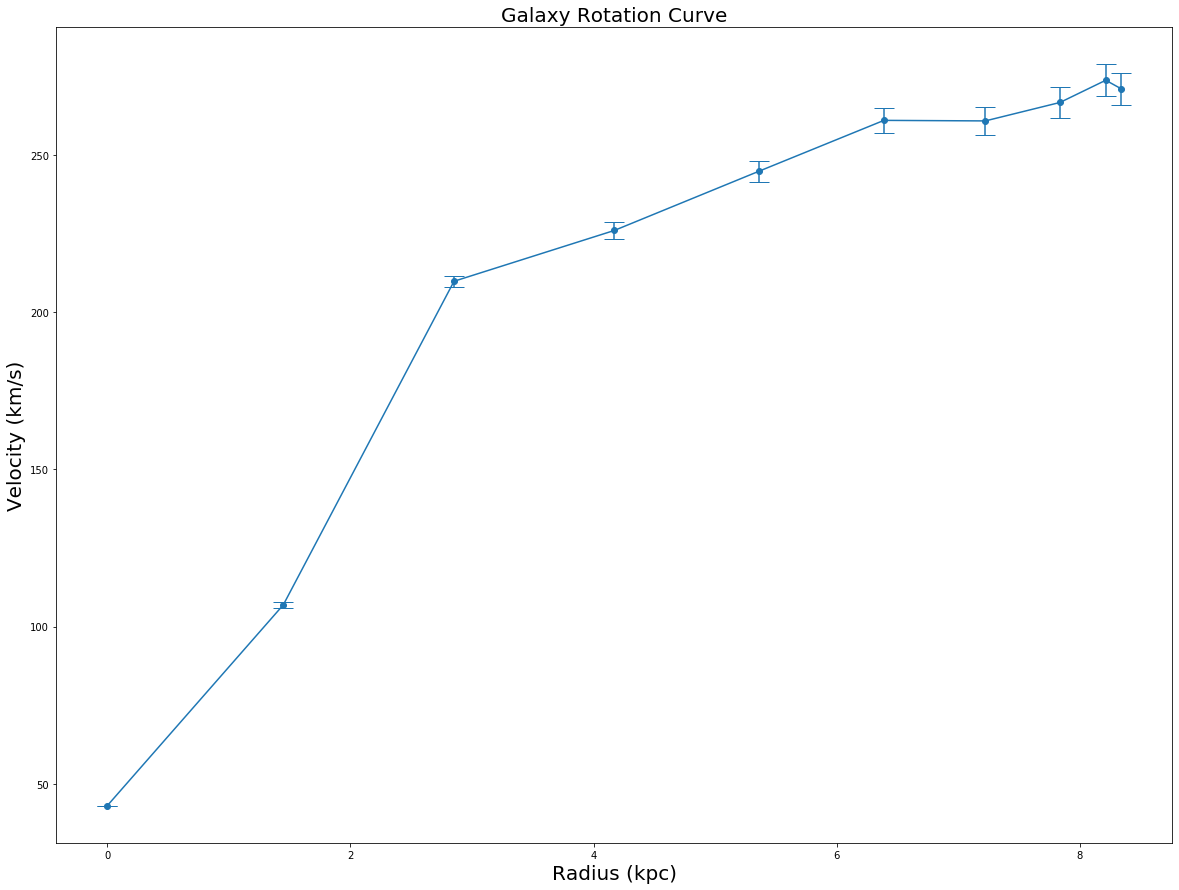

In [38]:
#plotting rotation curve with errors
fig, ax = plt.subplots(1,1, figsize=(20,15))
ax.scatter(radii, correct_vels)
ax.errorbar(radii, correct_vels, errors, capsize=10)
ax.set_xlabel('Radius (kpc)', fontsize=20)
ax.set_ylabel('Velocity (km/s)', fontsize=20)
ax.set_title('Galaxy Rotation Curve', fontsize=20)
plt.savefig(savedir+'rotationcurve.png')

In [7]:
#calculating enclosed mass
import astropy.units as u
from astropy.constants import G
from astropy.constants.iau2015 import M_sun

v=(271.1 * u.km / u.s).to(u.m/u.s)
r= (8.34*u.kpc).to(u.m)

m = (r*(v**2))/G
solar_m = m/M_sun

print('The enclosed mass is {} or {} solar masses.'.format(m, solar_m))

The enclosed mass is 2.8338980536105992e+41 kg or 142516122238.73987 solar masses.
